# Table of Contents

1. [Imports & Global Constants](#Imports-&-Global-Constants)
<br>&emsp;- 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
<br>

2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset)
<br>&emsp;- 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
<br>

3. [Define Dataset Class](#Define-Dataset-Class)
<br>&emsp;- 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
<br>

4. [Check Data Sample](#Check-Data-Sample)
<br>&emsp;- 제공된 데이터가 어떤 모습인지 확인합니다.
<br>

5. [Setup Dataloader](#Setup-Dataloader)
<br>&emsp;- 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
<br>

6. [Define Functions for Training](#Define-Functions-for-Training)
<br>&emsp;- 학습을 도와주는 함수들을 정의합니다.
<br>

7. [Training](#Training)
<br>&emsp;- 학습을 진행합니다.
<br>

8. [Inference](#Inference)
<br>&emsp;- 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
<br>

9. [Result Visualization](#Result-Visualization)
<br>&emsp;- 인퍼런스 결과를 확인해봅니다.
<br>

10. [To CSV](#To-CSV)
<br>&emsp;- 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A
import datetime
import pytz

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

# wandb
import wandb

In [2]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/opt/ml/input/data/train/DCM/"
LABEL_ROOT = "/opt/ml/input/data/train/outputs_json/"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [4]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [5]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [6]:
BATCH_SIZE = 2
LR = 1e-4
RANDOM_SEED = 21

NUM_EPOCHS = 300    # CHANGE
VAL_EVERY = 5

wandb.login()
kst = pytz.timezone('Asia/Seoul')
now = datetime.datetime.now(kst)
save_name = now.strftime('%Y_%m_%d_%H_%M_%S_') + 'Unet_2048'
SAVED_DIR = f"../workspace/{save_name}/"

if not os.path.isdir(SAVED_DIR):                                                           
    os.mkdir(SAVED_DIR)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mini123 (cv-06). Use `wandb login --relogin` to force relogin


# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [7]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [8]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [9]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [10]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [11]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [12]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [13]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # process a label of shape (H, W, NC)
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon to mask
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

# Check Data Sample

In [14]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [15]:
tf = A.Resize(2048, 2048)

In [16]:
train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)

In [17]:
image, label = train_dataset[0]

In [18]:
print(image.shape, label.shape)

torch.Size([3, 2048, 2048]) torch.Size([29, 2048, 2048])


In [19]:
len(train_dataset)

640

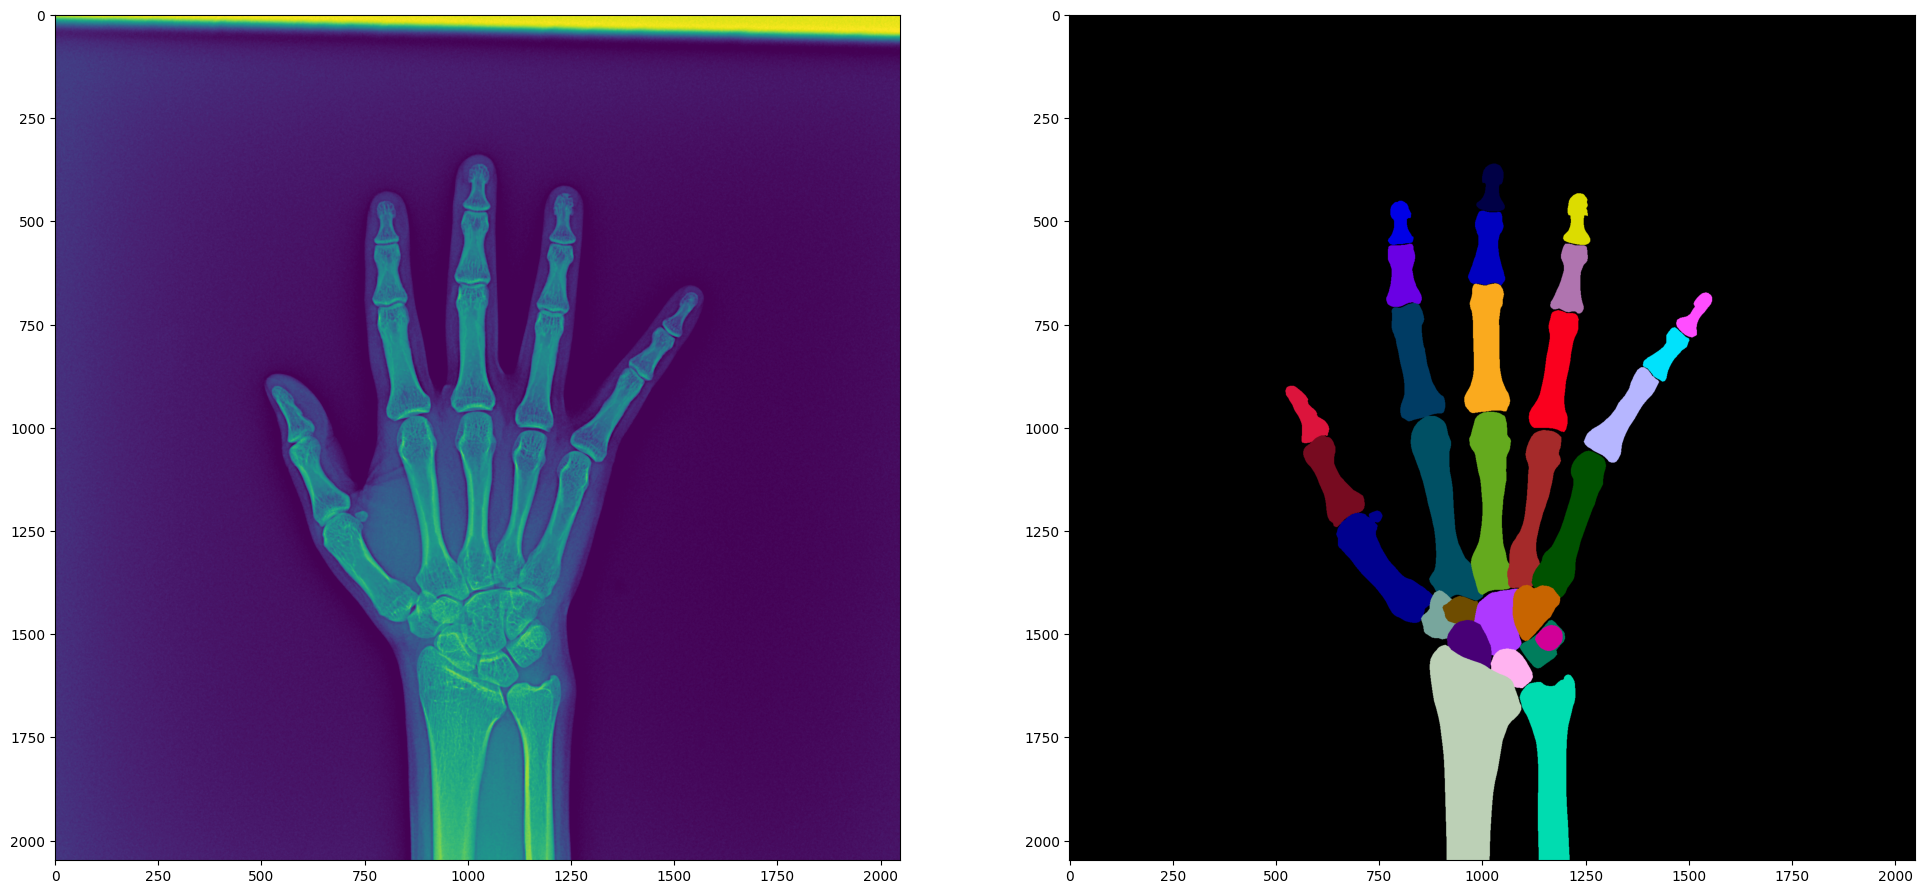

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # remove channel dimension
ax[1].imshow(label2rgb(label))

plt.show()

# Setup Dataloader

In [21]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    drop_last=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=1,
    shuffle=False,
    num_workers=1,
    drop_last=False
)

# Define Functions for Training

In [22]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [23]:
def save_model(model, file_name=f'{save_name}.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [24]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [25]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    set_seed()
    model.eval()

    dices = []
    with torch.no_grad():
        n_class = len(CLASSES)
        total_loss = 0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()         
            model = model.cuda()
            
            outputs = model(images)
            
            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)
            
            # restore original size
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()
            
            dice = dice_coef(outputs, masks)
            dices.append(dice)
                
    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(CLASSES, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)
    
    avg_dice = torch.mean(dices_per_class).item()
    
    return avg_dice

In [26]:
def train(model, data_loader, val_loader, criterion, optimizer):
    print(f'Start training..')
    set_seed()
    n_class = len(CLASSES)
    best_dice = 0.
    
    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, (images, masks) in enumerate(data_loader):            
            # gpu 연산을 위해 device 할당
            images, masks = images.cuda(), masks.cuda()
            model = model.cuda()
            
            # inference
            outputs = model(images)
            
            # loss 계산
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )
                wandb.log({"train_loss" : round(loss.item(),4)})
        wandb.log({"learning rate" : optimizer.param_groups[0]['lr']})
             
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)
            wandb.log({"val_dice" : dice})
            
            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)

# wandb init

In [27]:
wandb.init(
    project = "project3_Mini",
    entity = "cv-06",
    config = {
        "models" : "Unet",
        "epochs" : NUM_EPOCHS,
        "batch_size" : BATCH_SIZE,
        "learning_rate" : LR
    }
)
wandb.run.name = save_name

# Training

## `smp.Unet()`

In [28]:
# jupyter command 에서 library download 하기
#!pip install git+https://github.com/qubvel/segmentation_models.pytorch

import segmentation_models_pytorch as smp

# model 불러오기
# 출력 label 수 정의 (classes=29)
model = smp.Unet(
    encoder_name="efficientnet-b0", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=29,                     # model output channels (number of classes in your dataset)
)

In [29]:
# Loss function 정의
criterion = nn.BCEWithLogitsLoss()

# Optimizer 정의
optimizer = optim.Adam(params=model.parameters(), lr=LR, weight_decay=1e-6)

# scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [30]:
set_seed()

In [31]:
train(model, train_loader, valid_loader, criterion, optimizer)

Start training..
2023-06-20 11:45:44 | Epoch [1/300], Step [25/320], Loss: 0.635
2023-06-20 11:48:03 | Epoch [1/300], Step [50/320], Loss: 0.5526
2023-06-20 11:50:20 | Epoch [1/300], Step [75/320], Loss: 0.4709
2023-06-20 11:52:38 | Epoch [1/300], Step [100/320], Loss: 0.4073
2023-06-20 11:54:57 | Epoch [1/300], Step [125/320], Loss: 0.3512
2023-06-20 11:57:16 | Epoch [1/300], Step [150/320], Loss: 0.3047
2023-06-20 11:59:36 | Epoch [1/300], Step [175/320], Loss: 0.2655
2023-06-20 12:01:53 | Epoch [1/300], Step [200/320], Loss: 0.2339
2023-06-20 12:04:10 | Epoch [1/300], Step [225/320], Loss: 0.2068
2023-06-20 12:06:27 | Epoch [1/300], Step [250/320], Loss: 0.1845
2023-06-20 12:08:46 | Epoch [1/300], Step [275/320], Loss: 0.1663
2023-06-20 12:11:06 | Epoch [1/300], Step [300/320], Loss: 0.1496
2023-06-20 12:15:15 | Epoch [2/300], Step [25/320], Loss: 0.1252
2023-06-20 12:17:32 | Epoch [2/300], Step [50/320], Loss: 0.1147
2023-06-20 12:19:50 | Epoch [2/300], Step [75/320], Loss: 0.1061



finger-1    : 0.0000
finger-2    : 0.0000
finger-3    : 0.0000
finger-4    : 0.0000
finger-5    : 0.0000
finger-6    : 0.0000
finger-7    : 0.0000
finger-8    : 0.0000
finger-9    : 0.0000
finger-10   : 0.0000
finger-11   : 0.0000
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.0000
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.0000
Hamate      : 0.0000
Scaphoid    : 0.0000
Lunate      : 0.0000
Triquetrum  : 0.0000
Pisiform    : 0.0000
Radius      : 0.9710
Ulna        : 0.5521
Best performance at epoch: 5, 0.0000 -> 0.0525
Save model in ../workspace/2023_06_20_20_43_11_Unet_2048/
2023-06-20 14:20:42 | Epoch [6/300], Step [25/320], Loss: 0.0187
2023-06-20 14:22:58 | Epoch [6/300], Step [50/320], Loss: 0.0177
2023-06-20 14:25:12 | Epoch [6/300], Step [75/320], Loss: 0.0184
2023-06-20 14:27:25 | Epoch [6/300], Step [100/320], Loss: 0.017
2023-06-20 14:29:38 | Epo

KeyboardInterrupt: 

In [ ]:
wandb.finish()

# Inference

In [ ]:
model = torch.load(os.path.join(SAVED_DIR, f"{save_name}.pt"))

In [ ]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "/opt/ml/input/data/test/DCM/"

In [ ]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [ ]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [ ]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [ ]:
def test(model, data_loader, thr=0.5):
    set_seed()
    model = model.cuda()
    model.eval()
        
    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            outputs = model(images)
            
            # restore original size
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [ ]:
tf = A.Resize(2048, 2048)

In [ ]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [ ]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [ ]:
rles, filename_and_class = test(model, test_loader)

# Result Visualization

In [ ]:
filename_and_class[0]

In [ ]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [ ]:
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

# To CSV

In [ ]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

In [ ]:
image_name = [os.path.basename(f) for f in filename]

In [ ]:
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

In [ ]:
df.head(30)

In [ ]:
df.to_csv("output.csv", index=False)